# **PICKING WINNERS WITH NETWORK ANALYSIS**

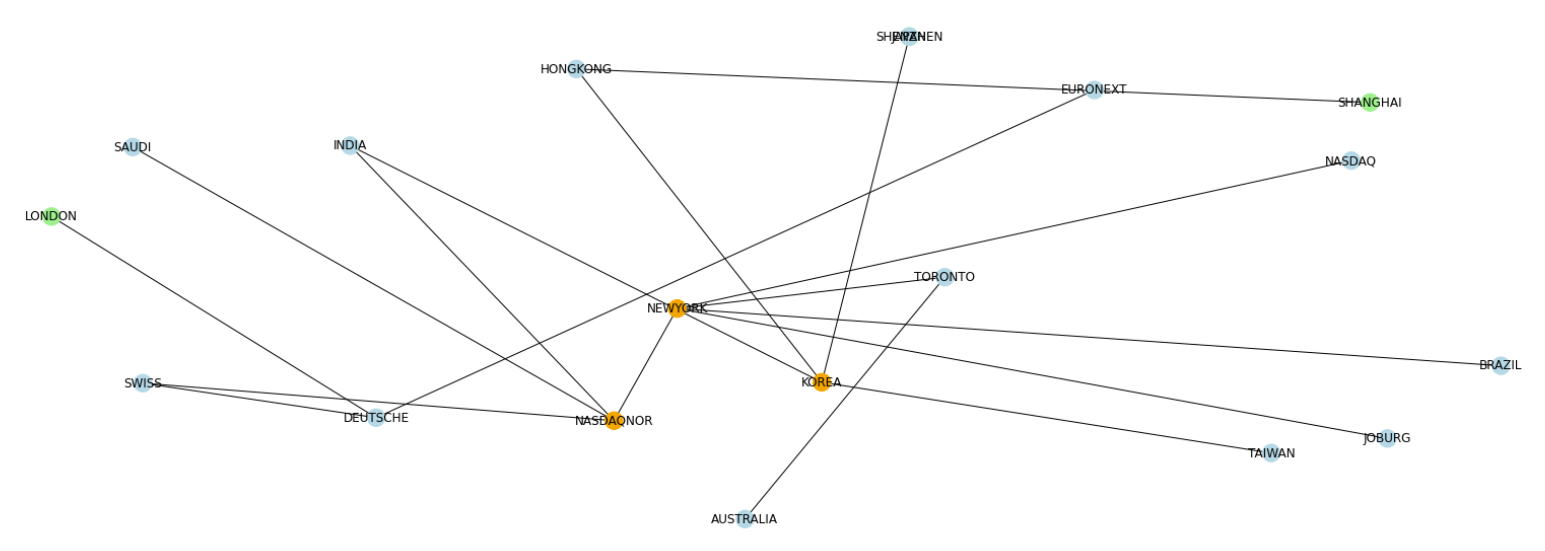

Active investment aims to beat average returns. A portfolio manager selects a set of assets that have a higher probability of better returns than some tracking index. In this article, we do just that. We use Network Analysis to select two baskets of stock exchanges and create portfolios to rival a global tracker. One portfolio consists of central stock exchanges, while the other contains outsiders. We then evaluate performance by simulating an investment kept for one year. A portfolio of outsiders could be the best choice when the economic outlook is uncertain.

**Note**: This article illustrates Network Analysis for stock markets, and it is not, in any way, financial advice.

In [1]:
# load the relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# mount drive if using google colab (wwhere this notebook was created)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. DATA**

Our analysis uses the [top 20](https://en.wikipedia.org/wiki/List_of_stock_exchanges) stock exchanges by market capitalisation, excluding Tehran Stock Exchange, because we could not find the data. We collected values for the period January 1, 2015, to December 31, 2022, from [Yahoo Finance](https://https://finance.yahoo.com/), with one exception: Saudi Stock Exchange (Tadawul) numbers were unavailable and downloaded from [Investing.com](https://uk.investing.com/indices/tasi-historical-data) instead. 

We reserve the 2022 data to evaluate performance later and use the remaining years to create our portfolios. Let’s load and check the data we will be working with. 

### **Load and check the data**

We manually constructed a csv file with 'Adj Close' data. It's possible to scrape Yahoo Finance with the [beautiful soup](https://https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library, but you will need to know the ticker symbol for each exchange. We had to look up the tickers and are dealing with only 19 entitites, so it made sense to simply download the data while on the page. Also, we find that scraping Yahoo Finance can be slow.

In [3]:
# the list of tickers for scraping yahoo finance (note that Saudi Arabia Tadawul is not available)
#tickers = ['^NYA', '^IXIC', '000001.SS', 'ENX.PA', 'JPXGY', '399001.SZ', '0388.HK', '^NSEI', 'LSEG.L', '^GSPTSE', '^SSMI', 'DB1.DE', '^OMX', 'ASX.AX', '^KS11', '^TWII', 'JSEJF', 'B3SA3.SA']

#### **Load the data**

In [4]:
# update the path and load the 2015-2021 data into a dataframe  
value_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/stocks_network/global_markets_2015_to_2021.csv')

#### **Check the data**

In [5]:
# check the dataframe content
value_data.head()

,DATE,NEWYORK,NASDAQ,SHANGHAI,EURONEXT,JAPAN,SHENZHEN,HONGKONG,INDIA,SAUDI,LONDON,TORONTO,SWISS,DEUTSCHE,NASDAQNOR,AUSTRALIA,KOREA,TAIWAN,JOBURG,BRAZIL
0,2015-01-05,10607.67969,4652.569824,3350.519043,21.226624,1174.170776,1174.171021,146.298935,8378.400391,8106.80,2004.493652,14392.70020,8938.849609,48.943855,1454.810059,27.789000,1915.750000,9274.076172,7.706398,2.268106
1,2015-01-06,10514.87012,4592.740234,3351.446045,21.302988,1139.796509,1139.796631,146.546417,8127.350098,8057.43,1977.208740,14246.79981,8874.469727,48.712082,1454.810059,27.375483,1882.449951,9048.306641,7.691579,2.290175
2,2015-01-07,10627.12988,4650.470215,3373.954102,21.339167,1119.675293,1119.675171,147.949188,8102.100098,8133.39,1991.760742,14285.00000,8900.830078,49.904022,1421.339966,27.405558,1883.829956,9080.055664,7.587838,2.380898
3,2015-01-08,10800.54004,4736.189941,3293.456055,20.888990,1136.024048,1136.023804,146.711472,8234.599609,8284.89,2015.407349,14457.70020,9139.690430,51.319447,1456.719971,27.593527,1904.650024,9237.996094,7.587838,2.349023
4,2015-01-09,10711.41016,4704.069824,3285.412109,20.643803,1148.599976,1148.599731,146.051315,8284.500000,8284.89,2014.497559,14384.90039,9105.700195,50.988354,1444.459961,27.946894,1924.699951,9215.545898,7.736038,2.287723


In [6]:
# check for missing values
value_data.isnull().sum()

DATE         0
NEWYORK      0
NASDAQ       0
SHANGHAI     0
EURONEXT     0
JAPAN        0
SHENZHEN     0
HONGKONG     0
INDIA        0
SAUDI        0
LONDON       0
TORONTO      0
SWISS        0
DEUTSCHE     0
NASDAQNOR    0
AUSTRALIA    0
KOREA        0
TAIWAN       0
JOBURG       0
BRAZIL       0
dtype: int64

In [7]:
# and check the data types 
value_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710 entries, 0 to 1709
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       1710 non-null   object 
 1   NEWYORK    1710 non-null   float64
 2   NASDAQ     1710 non-null   float64
 3   SHANGHAI   1710 non-null   float64
 4   EURONEXT   1710 non-null   float64
 5   JAPAN      1710 non-null   float64
 6   SHENZHEN   1710 non-null   float64
 7   HONGKONG   1710 non-null   float64
 8   INDIA      1710 non-null   float64
 9   SAUDI      1710 non-null   float64
 10  LONDON     1710 non-null   float64
 11  TORONTO    1710 non-null   float64
 12  SWISS      1710 non-null   float64
 13  DEUTSCHE   1710 non-null   float64
 14  NASDAQNOR  1710 non-null   float64
 15  AUSTRALIA  1710 non-null   float64
 16  KOREA      1710 non-null   float64
 17  TAIWAN     1710 non-null   float64
 18  JOBURG     1710 non-null   float64
 19  BRAZIL     1710 non-null   float64
dtypes: float

In [8]:
# the DATE column has dtype object - let's convert that to datetime
value_data['DATE'] = pd.to_datetime(value_data['DATE'])

Our data are complete with the correct Dtypes. We can move on to creating the graph in Fig 2.

### **Create the graph in Fig 2**

Fig 2 is a line graph showing the evolution of values from the beginning of 2015 to the end of 2021 for each stock exchange. The labels on the horizontal axis show the year at the beginning each period, and we have to set this up ourselves. The first date of trading varies by year - we need to find these dates and their indices so that we can place the labels correctly. 

In [9]:
# let's first extract the years into a new column called 'YEAR' 
# so that we can use the years as labels for the graph
value_data['YEAR'] = value_data['DATE'].dt.strftime('%Y')

In [10]:
# let's also extract days without timestamps into a new column called 'DAY'
# so that we can find the index for each first day of the year
value_data['DAY'] = value_data['DATE'].dt.strftime('%Y-%m-%d')

In [11]:
# do a quick check to verify that the new columns are added correctly at the end
value_data.head()

,DATE,NEWYORK,NASDAQ,SHANGHAI,EURONEXT,JAPAN,SHENZHEN,HONGKONG,INDIA,SAUDI,...,SWISS,DEUTSCHE,NASDAQNOR,AUSTRALIA,KOREA,TAIWAN,JOBURG,BRAZIL,YEAR,DAY
0,2015-01-05,10607.67969,4652.569824,3350.519043,21.226624,1174.170776,1174.171021,146.298935,8378.400391,8106.80,...,8938.849609,48.943855,1454.810059,27.789000,1915.750000,9274.076172,7.706398,2.268106,2015,2015-01-05
1,2015-01-06,10514.87012,4592.740234,3351.446045,21.302988,1139.796509,1139.796631,146.546417,8127.350098,8057.43,...,8874.469727,48.712082,1454.810059,27.375483,1882.449951,9048.306641,7.691579,2.290175,2015,2015-01-06
2,2015-01-07,10627.12988,4650.470215,3373.954102,21.339167,1119.675293,1119.675171,147.949188,8102.100098,8133.39,...,8900.830078,49.904022,1421.339966,27.405558,1883.829956,9080.055664,7.587838,2.380898,2015,2015-01-07
3,2015-01-08,10800.54004,4736.189941,3293.456055,20.888990,1136.024048,1136.023804,146.711472,8234.599609,8284.89,...,9139.690430,51.319447,1456.719971,27.593527,1904.650024,9237.996094,7.587838,2.349023,2015,2015-01-08
4,2015-01-09,10711.41016,4704.069824,3285.412109,20.643803,1148.599976,1148.599731,146.051315,8284.500000,8284.89,...,9105.700195,50.988354,1444.459961,27.946894,1924.699951,9215.545898,7.736038,2.287723,2015,2015-01-09


In [12]:
# make a list of unique years in the dataset
years = value_data['YEAR'].unique().tolist()
years

['2015', '2016', '2017', '2018', '2019', '2020', '2021']

In [13]:
# and find the first day of trading for each year
first_day = []

for year in years:
  first_day.append(value_data[value_data['YEAR']==year]['DAY'].min())

first_day

['2015-01-05',
 '2016-01-04',
 '2017-01-03',
 '2018-01-02',
 '2019-01-02',
 '2020-01-02',
 '2021-01-04']

In [14]:
# use the first day of trading to locate the relevant index and store it in a list
# the index comes as an array value, so we convert to a list in at the end
index_ticks = []

index_ticks.append(value_data[value_data['DAY']=='2015-01-05'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2016-01-04'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2017-01-03'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2018-01-02'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2019-01-02'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2020-01-02'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2021-01-04'].index.values)

# turn list of arrays into list of lists
index_ticks = [i.tolist() for i in index_ticks]

# combine lists of lists into a single list
ticks = sum(index_ticks, [])

ticks

[0, 245, 488, 733, 980, 1220, 1466]

[Text(0, 0.5, 'Stock exchange value'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'The 19 Stock Exchanges in our analysis')]

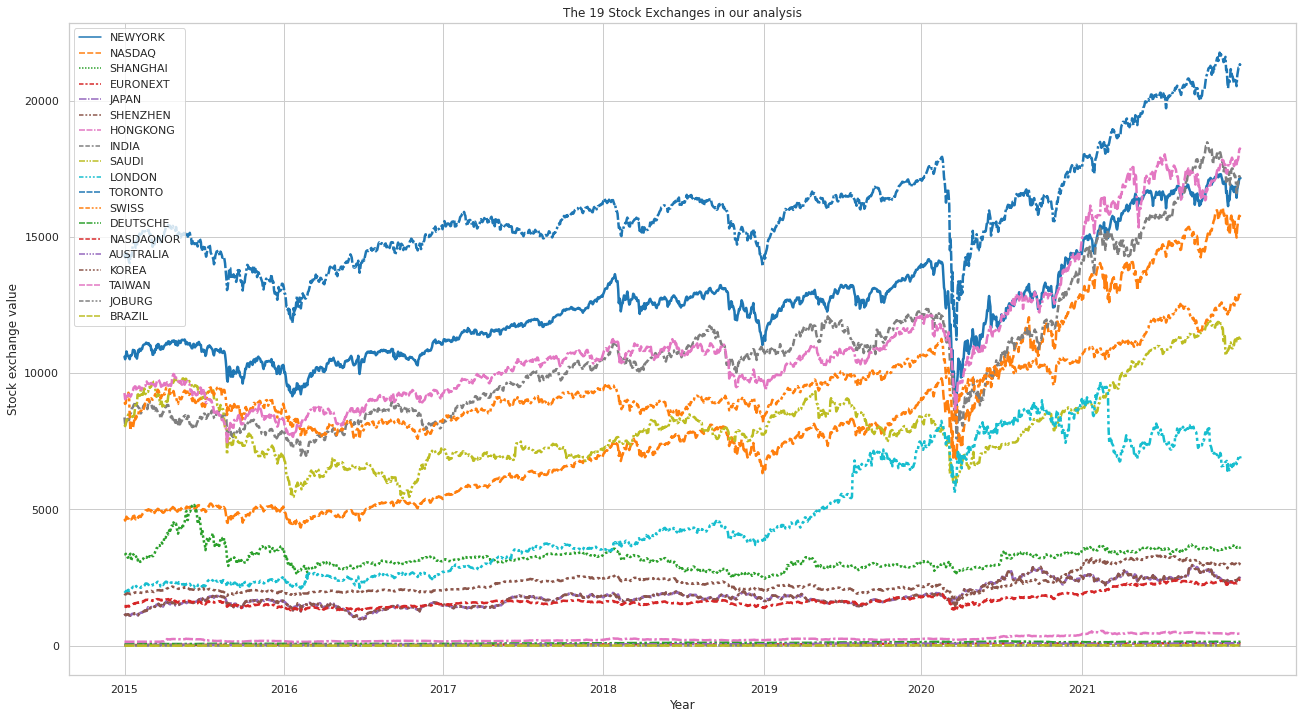

In [15]:
# Now we have everything we need to create the graph

# set the theme for the plot
sns.set_theme(style="whitegrid")

# create the plot
figure = plt.figure(figsize=(22,12))
g = sns.lineplot(data=value_data, palette="tab10", linewidth=2.5)

# set the ticks using the list of index values
g.set_xticks(ticks)

# set the label names for each tick using the list of years
g.set_xticklabels(years)

# add title and axis names
g.set(xlabel = 'Year',
      ylabel = 'Stock exchange value',
      title = 'The 19 Stock Exchanges in our analysis')

March 2020 immediately draws the eye: all major markets fell sharply at the beginning of the COVID-19 pandemic. But there are some easy-to-spot differences in the period that follows too. For example, the London Stock Exchange (light blue) and the SIX Swiss Exchange (orange) do not display the same recovery as other big markets. We also see some contrasting trends in 2017 and 2018. The Korea Exchange (brown) and the German Xetra (green) mainly remained flat, while many other stock markets saw growth. That is good news for our analysis; we may find patterns in the variation.

## **2. FINDING THE NETWORK**

Now we determine the network for our 19 stock exchanges in three steps. First, we calculate daily returns. Second, we find the correlations between the returns for each stock exchange and every other stock exchange. And finally, we convert the correlation coefficients into distances and draw a network that maintains only the significant links. Let’s look at each step in more detail.

### **Calculate daily returns**

We use daily log returns. There are two good reasons for this choice. One, simple returns tend to follow a log-normal distribution. So if we use log returns, we can work with a normal distribution, and the normal distribution makes life easy. And two, we are interested in multiplicative returns: we want to know whether a stock doubled in value rather than that it increased by, say, 5 dollars.

We calculate daily log returns using the shift() function to move the Adjusted Close data to the next day. Then we take the difference with the original data to get a daily change.

In [16]:
# set DATE as index so we can use the shift() function
value_data.set_index('DATE', inplace=True)

In [17]:
# drop YEAR and DAY columns because they are not relevant
value_data = value_data.drop(columns = ['YEAR', 'DAY'])

In [18]:
# check that the dataframe looks as expected
value_data

,NEWYORK,NASDAQ,SHANGHAI,EURONEXT,JAPAN,SHENZHEN,HONGKONG,INDIA,SAUDI,LONDON,TORONTO,SWISS,DEUTSCHE,NASDAQNOR,AUSTRALIA,KOREA,TAIWAN,JOBURG,BRAZIL
DATE,,,,,,,,,,,,,,,,,,,
2015-01-05,10607.67969,4652.569824,3350.519043,21.226624,1174.170776,1174.171021,146.298935,8378.400391,8106.80,2004.493652,14392.70020,8938.849609,48.943855,1454.810059,27.789000,1915.750000,9274.076172,7.706398,2.268106
2015-01-06,10514.87012,4592.740234,3351.446045,21.302988,1139.796509,1139.796631,146.546417,8127.350098,8057.43,1977.208740,14246.79981,8874.469727,48.712082,1454.810059,27.375483,1882.449951,9048.306641,7.691579,2.290175
2015-01-07,10627.12988,4650.470215,3373.954102,21.339167,1119.675293,1119.675171,147.949188,8102.100098,8133.39,1991.760742,14285.00000,8900.830078,49.904022,1421.339966,27.405558,1883.829956,9080.055664,7.587838,2.380898
2015-01-08,10800.54004,4736.189941,3293.456055,20.888990,1136.024048,1136.023804,146.711472,8234.599609,8284.89,2015.407349,14457.70020,9139.690430,51.319447,1456.719971,27.593527,1904.650024,9237.996094,7.587838,2.349023
2015-01-09,10711.41016,4704.069824,3285.412109,20.643803,1148.599976,1148.599731,146.051315,8284.500000,8284.89,2014.497559,14384.90039,9105.700195,50.988354,1444.459961,27.946894,1924.699951,9215.545898,7.736038,2.287723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-22,16874.88086,15521.889650,3622.620117,85.993736,2450.277588,2450.277588,437.745819,16955.449220,11215.58,6837.314941,21070.09961,12713.900390,141.242691,2334.810059,88.506622,2984.479980,17826.830080,6.282323,11.033402
2021-12-23,16963.43945,15653.370120,3643.340088,87.018044,2464.004639,2464.004639,441.654266,17072.599610,11272.55,6932.113281,21218.90039,12785.320310,142.958588,2385.629883,88.603645,2998.169922,17946.660160,6.820543,10.918272
2021-12-28,17134.16016,15781.719730,3630.112061,88.042366,2491.458496,2491.458496,444.976440,17233.250000,11312.10,6932.113281,21218.90039,12970.530270,144.772522,2420.469971,88.603645,3020.239990,18196.810550,6.820543,10.707199


In [19]:
# check that shift(1) works as expected, moving the adjusted close from day n to day n+1
value_data.shift(1)

,NEWYORK,NASDAQ,SHANGHAI,EURONEXT,JAPAN,SHENZHEN,HONGKONG,INDIA,SAUDI,LONDON,TORONTO,SWISS,DEUTSCHE,NASDAQNOR,AUSTRALIA,KOREA,TAIWAN,JOBURG,BRAZIL
DATE,,,,,,,,,,,,,,,,,,,
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,10607.67969,4652.569824,3350.519043,21.226624,1174.170776,1174.171021,146.298935,8378.400391,8106.80,2004.493652,14392.70020,8938.849609,48.943855,1454.810059,27.789000,1915.750000,9274.076172,7.706398,2.268106
2015-01-07,10514.87012,4592.740234,3351.446045,21.302988,1139.796509,1139.796631,146.546417,8127.350098,8057.43,1977.208740,14246.79981,8874.469727,48.712082,1454.810059,27.375483,1882.449951,9048.306641,7.691579,2.290175
2015-01-08,10627.12988,4650.470215,3373.954102,21.339167,1119.675293,1119.675171,147.949188,8102.100098,8133.39,1991.760742,14285.00000,8900.830078,49.904022,1421.339966,27.405558,1883.829956,9080.055664,7.587838,2.380898
2015-01-09,10800.54004,4736.189941,3293.456055,20.888990,1136.024048,1136.023804,146.711472,8234.599609,8284.89,2015.407349,14457.70020,9139.690430,51.319447,1456.719971,27.593527,1904.650024,9237.996094,7.587838,2.349023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-22,16744.26953,15341.089840,3625.129883,85.603516,2424.784424,2424.784424,437.354980,16770.849610,11287.75,6718.817383,20924.90039,12682.530270,141.634888,2319.520020,88.661858,2975.030029,17789.269530,6.263764,10.908679
2021-12-23,16874.88086,15521.889650,3622.620117,85.993736,2450.277588,2450.277588,437.745819,16955.449220,11215.58,6837.314941,21070.09961,12713.900390,141.242691,2334.810059,88.506622,2984.479980,17826.830080,6.282323,11.033402
2021-12-28,16963.43945,15653.370120,3643.340088,87.018044,2464.004639,2464.004639,441.654266,17072.599610,11272.55,6932.113281,21218.90039,12785.320310,142.958588,2385.629883,88.603645,2998.169922,17946.660160,6.820543,10.918272


In [20]:
# and calculate the log returns in a new dataframe
log_returns_2015_to_2021 = np.log(value_data) - np.log(value_data.shift(1))

### **Find the correlations**

We calculate the correlations between log returns for each stock exchange with every other stock exchange, and create the heatmap in Fig 3. 

In [21]:
# calculate the corrections
returns_corr_2015_to_2021 = log_returns_2015_to_2021.corr()

Text(0.5, 1.0, 'correlation heatmap for log returns over the period 2015 to 2021')

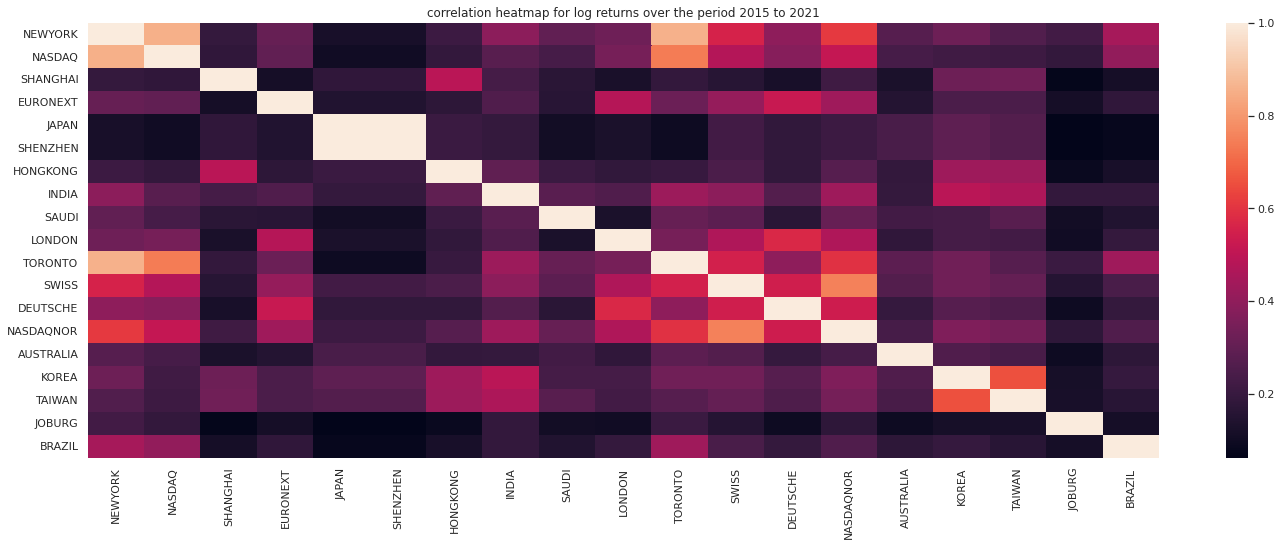

In [22]:
# create the heatmap
figure = plt.figure(figsize=(24, 8))
corr_heatmap = sns.heatmap(returns_corr_2015_to_2021)
corr_heatmap.set_title('correlation heatmap for log returns over the period 2015 to 2021')

Light colours indicate strong positive correlations, and dark colours are zero or negative correlations. So Japan and Shenzhen, for example, move together but independently of all other exchanges.

We can also use the correlation matrix to draw a fully connected network like in Fig 4.

In [23]:
# define data for the fully connected graph
fully_connected_graph = nx.Graph(returns_corr_2015_to_2021)

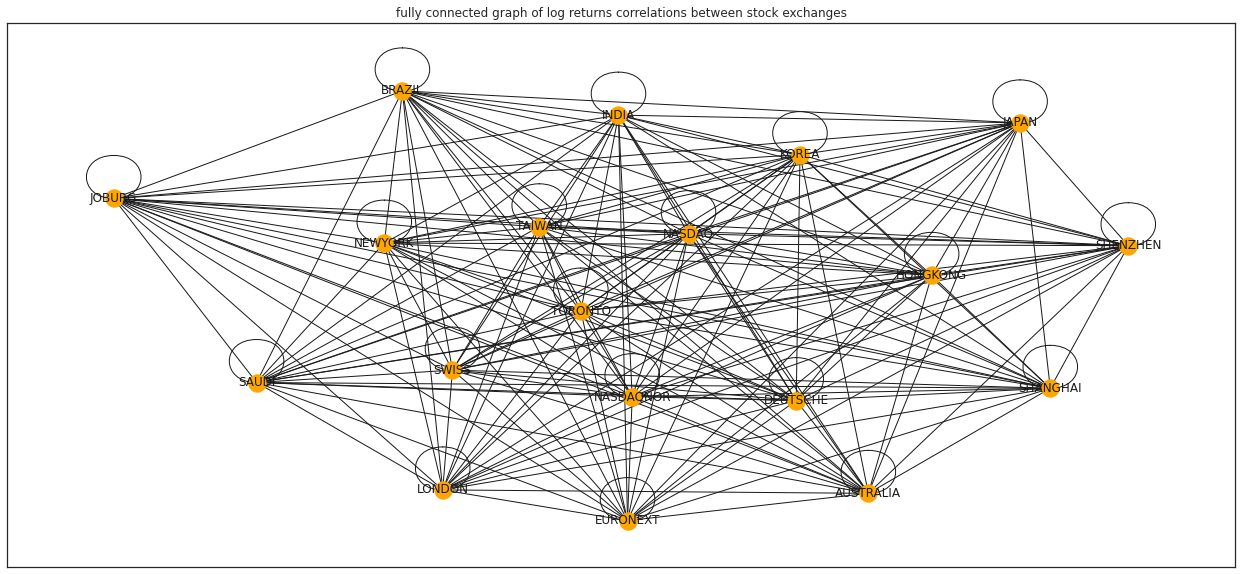

In [24]:
# and draw the graph
sns.set_theme(style="white")

figure = plt.figure(figsize=(22, 10))
plt.title('fully connected graph of log returns correlations between stock exchanges')

nx.draw_networkx(fully_connected_graph, with_labels=True, node_color='orange')

Each orange circle (*node*) represents one of the 19 stock exchanges, and the nodes are connected by lines (*edges*). A thicker edge indicates a stronger correlation between two nodes, and a loop is the correlation of a node with itself.

### **Draw the network**

The network would be more informative if we eliminated redundancies and noise. A Minimum Spanning Tree (MST) can help identify the relationships that matter. First, we need distances of some kind. We convert the correlation coefficients into distances by taking the square root of 2 * (1 – correlation coefficient). That gives us short distances between nodes with high correlations and longer distances otherwise. Then we can generate the MST and visualise the network of meaningful relationships in Fig 5.

In [25]:
# calculate distances
distance = np.sqrt(2 * (1 - returns_corr_2015_to_2021))

# generate a graph the distances distances
distance_graph = nx.Graph(distance)

# define the mst from the graph with distances
distance_graph_mst = nx.minimum_spanning_tree(distance_graph)

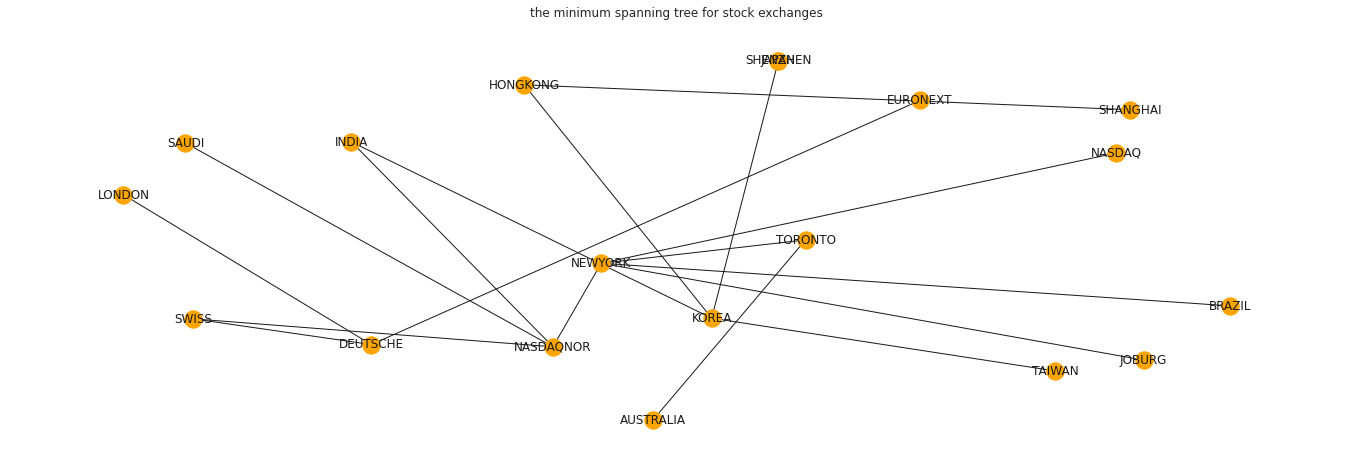

In [26]:
# and visualise the graph
figure = plt.figure(figsize=(24, 8))
plt.title('the minimum spanning tree for stock exchanges')

nx.draw_kamada_kawai(distance_graph_mst, with_labels=True, node_color='orange')

## **3. CALCULATING METRICS**

Now we are ready to calculate three Network Analysis metrics to guide the portfolio selection: degree centrality, betweenness centrality, and closeness centrality. They measure a node’s importance, but each has a different emphasis. Let’s see what that is.

### **Degree centrality**

Degree centrality is the simplest measure: it is the number of connections expressed as a fraction of the total possible connections.  A node with a high degree centrality influences the behaviour of many others.

In our network, New York has the most connections (Fig 5) and, therefore, the highest degree centrality. It has links with five other exchanges out of a possible 18, so its degree centrality is 5 / 18 = 0.28. Note that the edge between Korea and India runs behind New York, making it look like seven links, but the line does not connect. Fig 6 has the values for all exchanges.

In [27]:
# calculate degree centrality in the mst using the networkx built-in function
degree_centrality = nx.degree_centrality(distance_graph_mst)

In [28]:
# create the vertical bar chart in figure 6

# initialise empty lists
keys = []
values = []

# append the results for each stock exchange to the empty lists
for key, value in degree_centrality.items():
  keys.append(key)
  values.append(value)

# store data in data frame
degree_data = pd.DataFrame({'stock_exchanges': keys, 'degree_centrality': values}).sort_values('degree_centrality', ascending=False)

# display the graph
px.bar(data_frame=degree_data, x='stock_exchanges', y='degree_centrality', template='plotly_white')

### **Betweenness centrality**

Betweenness centrality measures a node’s influence over the flow of information in the network. It’s the number of shortest paths that pass through it. The shortest path is the minimum number of hops from one node to another. For example, to get from Nasdaq Nordic (NASDAQNOR) to Toronto takes two jumps on the shortest path: first to New York and then to Toronto. We can go via India first, but with three hops, that’s not the shortest path.

It’s tempting to think that the node with the most connections also has the most shortest paths. It can be, but it often isn’t. The picture in Fig 7, also shown below, helps to illustrate why.

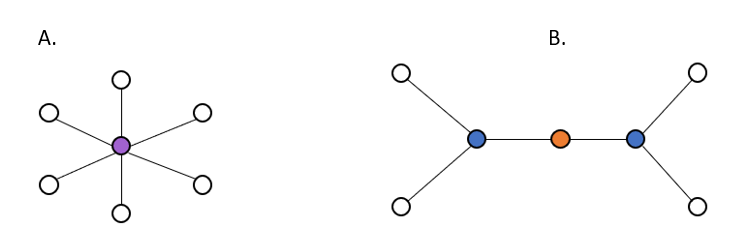

A and B each have seven nodes and six edges, but the networks have different structures. Network A has a star shape. The purple node in the middle has the highest degree centrality with six connections and the highest betweenness centrality because it is on the shortest path between any other two nodes.

In network B, however, the roles fall on separate nodes. The blue nodes have the highest degree centrality, with three connections each. But the orange node has the highest betweenness centrality: every shortest path from the left to the right side, and vice versa, has to pass through it. It’s a bridge between the two larger components of the network. Shapes like network B are more common in the real world, so the highest degree and betweenness centrality are often different nodes.

Below we create Fig 8, which displays the betweenness centralities for every node in our network. Nasdaq Nordic has the highest score. Any exchange with one connection gets zero because no path can pass through it.

In [29]:
# calculate betweennes centrality in the mst using the networkx built-in function
betweenness_centrality = nx.betweenness_centrality(distance_graph_mst)

In [30]:
# create the vertical bar chart in figure 8

# initialise empty lists
keys = []
values = []

# append the results for each stock exchange to the empty lists
for key, value in betweenness_centrality.items():
  keys.append(key)
  values.append(value)

# store data in data frame
betweenness_data = pd.DataFrame({'stock_exchanges': keys, 'betweenness_centrality': values}).sort_values('betweenness_centrality', ascending=False)

# display the graph
px.bar(data_frame=betweenness_data, x='stock_exchanges', y='betweenness_centrality', template='plotly_white')

### **Closeness centrality**

Closeness centrality expresses how close a node is to all other nodes. It measures the lengths of the shortest paths between a node and all other nodes that can be reached from it. We calculate it as the reciprocal of the sum of the shortest paths, and Fig 9 -also shown below- helps us see how that works.

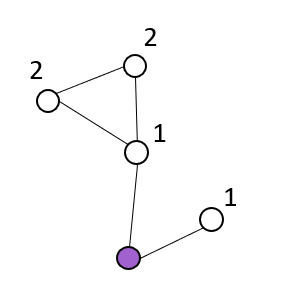

Let’s compute closeness centrality for the purple node. There are four other nodes in the network, and they can all be reached. The numbers indicate the shortest path length from the purple node to that node. Then, the closeness centrality for the purple node is 4 / (1 + 1 + 2 + 2) = 4 / 6 = 2 / 3.

Nasdaq Nordic has the highest closeness centrality in our network of stock exchanges. It also has the highest betweenness centrality, but, once again, it is only sometimes that the same node takes both roles. Fig 10 below displays the complete set of closeness centralities.

In [31]:
# calculate closeness centrality in the mst using the networkx built-in function
closeness_centrality = nx.closeness_centrality(distance_graph_mst)

In [32]:
# create the vertical bar chart in figure 10

# initialise empty lists
keys = []
values = []

# append the results for each stock exchange to the empty lists
for key, value in closeness_centrality.items():
  keys.append(key)
  values.append(value)

# store data in data frame
closeness_data = pd.DataFrame({'stock_exchanges': keys, 'closeness_centrality': values}).sort_values('closeness_centrality', ascending=False)

# display the graph
px.bar(data_frame=closeness_data, x='stock_exchanges', y='closeness_centrality', template='plotly_white')

## **4. CREATING THE PORTFOLIOS**

Our two portfolios are on opposite ends. Stock exchanges in the central portfolio play a key role and influence other exchanges worldwide. However, exchanges in the outsiders portfolio have weak correlations and contain more noise.

The three metrics we calculated focus on different aspects of a node’s importance, and we take the average to reduce the error caused by any single method.

In [33]:
# make a dataframe with the metrics we calculated
metrics = pd.DataFrame.from_dict(dict(degree_centrality), orient='index')
metrics.columns = ['degree_centrality']
metrics['betweenness_centrality'] = betweenness_centrality.values()
metrics['closeness_centrality'] = closeness_centrality.values()  

# and add the average_centrality measure
metrics['average_centrality'] = (metrics['degree_centrality'] + metrics['betweenness_centrality'] + metrics['closeness_centrality']) / 3

In [34]:
# check that the dataframe looks as expected
metrics.head()

,degree_centrality,betweenness_centrality,closeness_centrality,average_centrality
NEWYORK,0.277778,0.48366,0.367347,0.376262
NASDAQ,0.055556,0.00000,0.272727,0.109428
SHANGHAI,0.055556,0.00000,0.209302,0.088286
EURONEXT,0.055556,0.00000,0.216867,0.090808
JAPAN,0.055556,0.00000,0.209302,0.088286


In [35]:
# create the central portfolio taking the top 3 who score highest on average_centrality
central_portfolio = metrics.sort_values('average_centrality', ascending=False).head(3)

# and store the result in list of central exchanges for visualisation in the network for Fig 12
central_exchanges = [exchange for exchange in central_portfolio.index.values]

In [36]:
# create outsiders portfolio taking the top 3 who score lowest on average_centrality
outsiders_portfolio = metrics.sort_values('average_centrality', ascending=True).head(3)

# and store the result a list of outsider exchanges for visualisation in the network for Fig 12
outsider_exchanges = [exchange for exchange in outsiders_portfolio.index.values]

Now we can look at the tables in Fig 11. Nasdaq Nordic, New York and Korea have the highest average scores and go in the central portfolio. Shanghai, Japan and London have the lowest scores and make up the outsiders portfolio. 

In [37]:
central_portfolio

,degree_centrality,betweenness_centrality,closeness_centrality,average_centrality
NASDAQNOR,0.222222,0.725490,0.428571,0.458761
NEWYORK,0.277778,0.483660,0.367347,0.376262
KOREA,0.222222,0.477124,0.333333,0.344227


In [38]:
outsiders_portfolio

,degree_centrality,betweenness_centrality,closeness_centrality,average_centrality
SHANGHAI,0.055556,0.0,0.209302,0.088286
JAPAN,0.055556,0.0,0.209302,0.088286
LONDON,0.055556,0.0,0.216867,0.090808


Let’s visualise that in the network and create Fig 12. 

In [39]:
# check that the values in the stored list of central_exchanges match central_portfolio
central_exchanges

['NASDAQNOR', 'NEWYORK', 'KOREA']

In [40]:
# and also check that the values in the stored list of outsider_exchanges match outsiders_portfolio
outsider_exchanges

['SHANGHAI', 'JAPAN', 'LONDON']

In [41]:
# then use the two lists to set the colours for central, outsider and regular nodes in the network graph

# initialise an empty list
colours = []

# orange for central nodes, green for outsiders, and blue for all others
for node in distance_graph_mst:
    if node in central_exchanges:
        colours.append('orange')
        
    elif node in outsider_exchanges:
        colours.append('lightgreen')
        
    else:
        colours.append('lightblue')

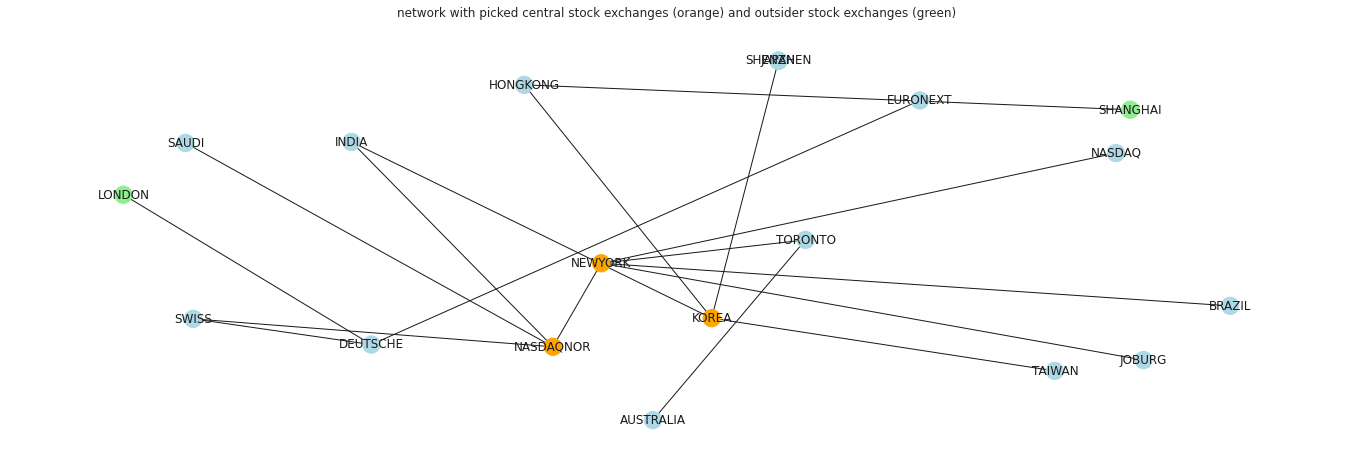

In [42]:
# create the figure
figure = plt.figure(figsize=(24, 8))
plt.title('network with picked central stock exchanges (orange) and outsider stock exchanges (green)')

# visualise the network
nx.draw_kamada_kawai(distance_graph_mst, with_labels=True, node_color=colours)

That's Fig 12. Japan is difficult to see – it is located behind Shenzhen, all the way at the top. But our results make intuitive sense: the central portfolio is near the centre of the network, and the outsiders are, well, on the outside.

## **5. EVALUATE PERFORMANCE**

Say we did our analysis at the end of 2021, and on the first day of trading in 2022, we spent 100.000 on either a central portfolio, an outsiders portfolio, or a global tracker. What would have happened? We create Fig 13 to shows us.

Note that we conveniently ignore currencies and exchange rates. This article aims to illustrate Network Analysis rather than to provide accurate investment advice.

In [43]:
# we need all the values for 2022 - upload the data after updating the path
value_data_2022 = price_data_2022 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/stocks_network/global_markets_2022.csv', index_col=[0])

In [44]:
# check that the dataframe looks as expected
value_data_2022

,NEWYORK,NASDAQ,SHANGHAI,EURONEXT,JAPAN,SHENZHEN,HONGKONG,INDIA,SAUDI,LONDON,TORONTO,SWISS,DEUTSCHE,NASDAQNOR,AUSTRALIA,KOREA,TAIWAN,JOBURG,BRAZIL
DATE,,,,,,,,,,,,,,,,,,,
2022-01-04,17336.75977,15622.71973,3632.330078,86.042511,2469.397217,2469.397217,439.309235,17805.25000,11358.58,6979.512207,21236.50000,12900.96973,143.693970,2456.169922,89.476875,2989.239990,18526.34961,6.727746,10.552873
2022-01-05,17112.59961,15100.16992,3595.179932,86.042511,2485.085205,2485.085205,430.124359,17925.25000,11427.73,7098.009766,21039.69922,12906.37012,144.135193,2442.810059,88.720078,2953.969971,18499.96094,6.319442,10.331216
2022-01-06,17156.51953,15080.86035,3586.080078,86.383949,2426.745361,2426.745361,425.043365,17745.90039,11452.98,6941.988281,21072.19922,12792.28027,143.988129,2442.810059,86.993027,2920.530029,18367.91992,6.718467,10.581784
2022-01-07,17166.27930,14935.90039,3579.540039,83.701218,2433.608887,2433.608887,439.113770,17812.69922,11452.98,6979.512207,21084.50000,12797.94043,142.713455,2400.949951,87.982681,2954.889893,18169.75977,6.718467,10.832355
2022-01-10,17119.56055,14942.83008,3593.520020,83.018341,2433.608887,2433.608887,447.712372,18003.30078,11675.81,7082.209961,21072.30078,12597.34961,143.939102,2352.729980,87.778938,2926.719971,18239.38086,6.718467,10.774533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,15081.53027,10476.12012,3054.429932,70.040001,1874.000000,1874.000000,337.399994,18127.34961,10230.96,7188.000000,19349.69922,10774.63965,163.550003,2043.300049,67.900002,2356.729980,14442.94043,5.710000,12.236244
2022-12-23,15188.45020,10497.86035,3045.865967,70.120003,1884.500000,1884.500000,340.000000,17806.80078,10230.96,7130.000000,19506.69922,10804.67969,163.449997,2054.330078,67.610001,2313.689941,14271.62988,5.710000,13.285341
2022-12-28,15037.32031,10213.29004,3087.399902,70.000000,1892.500000,1892.500000,342.600006,18122.50000,10482.07,7128.000000,19284.09961,10812.66992,162.250000,2052.760010,68.010002,2280.449951,14173.09961,6.110000,13.335098


In [45]:
# calculate the average of 2022 across all stock exchanges - we will use this average for our 'global tracker'
value_data_2022['global'] = value_data_2022.mean(axis=1)

In [46]:
# Check that it has been added at the end
value_data_2022.head()

,NEWYORK,NASDAQ,SHANGHAI,EURONEXT,JAPAN,SHENZHEN,HONGKONG,INDIA,SAUDI,LONDON,TORONTO,SWISS,DEUTSCHE,NASDAQNOR,AUSTRALIA,KOREA,TAIWAN,JOBURG,BRAZIL,global
DATE,,,,,,,,,,,,,,,,,,,,
2022-01-04,17336.75977,15622.71973,3632.330078,86.042511,2469.397217,2469.397217,439.309235,17805.25000,11358.58,6979.512207,21236.50000,12900.96973,143.693970,2456.169922,89.476875,2989.239990,18526.34961,6.727746,10.552873,7187.314667
2022-01-05,17112.59961,15100.16992,3595.179932,86.042511,2485.085205,2485.085205,430.124359,17925.25000,11427.73,7098.009766,21039.69922,12906.37012,144.135193,2442.810059,88.720078,2953.969971,18499.96094,6.319442,10.331216,7149.346987
2022-01-06,17156.51953,15080.86035,3586.080078,86.383949,2426.745361,2426.745361,425.043365,17745.90039,11452.98,6941.988281,21072.19922,12792.28027,143.988129,2442.810059,86.993027,2920.530029,18367.91992,6.718467,10.581784,7114.382504
2022-01-07,17166.27930,14935.90039,3579.540039,83.701218,2433.608887,2433.608887,439.113770,17812.69922,11452.98,6979.512207,21084.50000,12797.94043,142.713455,2400.949951,87.982681,2954.889893,18169.75977,6.718467,10.832355,7103.854259
2022-01-10,17119.56055,14942.83008,3593.520020,83.018341,2433.608887,2433.608887,447.712372,18003.30078,11675.81,7082.209961,21072.30078,12597.34961,143.939102,2352.729980,87.778938,2926.719971,18239.38086,6.718467,10.774533,7118.572217


In [47]:
# make a new dataframe with the 2022 average values only
value_data_2022_average = value_data_2022['global'].to_frame()

In [48]:
# check that it looks ok
value_data_2022_average.head()

,global
DATE,
2022-01-04,7187.314667
2022-01-05,7149.346987
2022-01-06,7114.382504
2022-01-07,7103.854259
2022-01-10,7118.572217


In [49]:
# now take the value of each stock exchange on the first day of 2022
first_day_2022 = value_data_2022_average['2022-01-04':]

In [50]:
# and calculate the values of the central_portfolio and the outsiders_portfolio as if we had invested 100000 in each

amount = 100000

central_portfolio_value = pd.DataFrame()
for exchange in central_exchanges:
    central_portfolio_value[exchange] = value_data_2022[exchange]
    
portfolio_unit = central_portfolio_value.sum(axis=1)[0]
share = amount / portfolio_unit
central_portfolio_value = central_portfolio_value.sum(axis=1) * share

outsiders_portfolio_value = pd.DataFrame()
for exchange in outsider_exchanges:
    outsiders_portfolio_value[exchange] = value_data_2022[exchange]
    
portfolio_unit = outsiders_portfolio_value.sum(axis=1)[0]
share = amount / portfolio_unit
outsiders_portfolio_value = outsiders_portfolio_value.sum(axis=1) * share

In [51]:
# also calculate the value of the 'global tracker' as if we had invested 100000
global_average_2022_value = value_data_2022_average * (amount / value_data_2022_average.iloc[0])

In [52]:
# combine all portfolios into a new dataframe
all_portfolios = global_average_2022_value
all_portfolios['central_portfolio'] = central_portfolio_value
all_portfolios['outsiders_portfolio'] = outsiders_portfolio_value.values

In [53]:
# check that the dataframe with all portfolios looks as expected
all_portfolios

,global,central_portfolio,outsiders_portfolio
DATE,,,
2022-01-04,100000.000000,100000.000000,100000.000000
2022-01-05,99471.740386,98802.616055,100741.790570
2022-01-06,98985.265470,98848.616845,99033.533619
2022-01-07,98838.781766,98858.534803,99322.859512
2022-01-10,99043.558633,98318.162026,100214.806601
...,...,...,...
2022-12-22,86065.769267,85512.313230,92624.478973
2022-12-23,85882.409623,85841.122650,92195.896002
2022-12-28,85765.846809,85024.958296,92559.270856


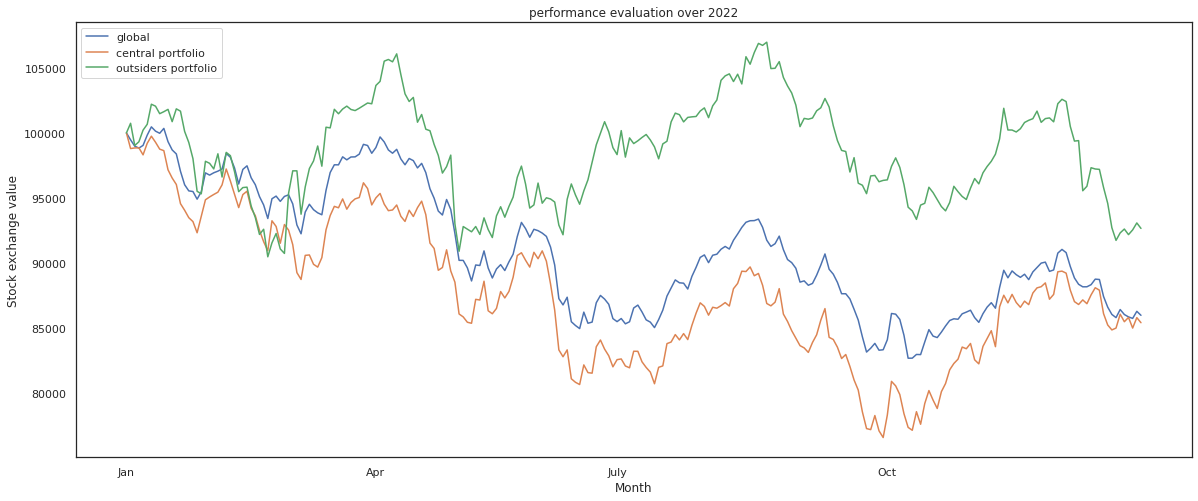

In [54]:
# Finally we create the line graph to evaluate the performance of the central, outsiders and global portfolios

# set the figure
figure, ax = plt.subplots(figsize=(20, 8))
global_portfolio_line = ax.plot(all_portfolios['global'], label='global')
central_portfolio_line = ax.plot(all_portfolios['central_portfolio'], label= 'central portfolio')
outsiders_portfolio_line = ax.plot(all_portfolios['outsiders_portfolio'], label= 'outsiders portfolio')
ax.legend(loc='upper left')

# set the ticks and labels for the horizontal axis
ax.set_xticks([0, 60, 118, 183])
ax.set_xticklabels(['Jan', 'Apr', 'July', 'Oct'])

# set plot title and axis names
ax.set(xlabel = 'Month',
      ylabel = 'Stock exchange value',
      title = 'performance evaluation over 2022')

plt.show()

Clearly, 2022 was not great for stock markets. At the end of the year, we would be down on our investment regardless of the choice we made at the beginning. But losses would be lowest with the portfolio of outsiders. Their low correlation with highly influential markets can help them escape a downturn.

By the end of 2021, we already suspected that 2022 would not be rosy. If we had combined that intuition with the knowledge about weakly correlated markets and which ones they are, we would have made the right choice. Probably